<a href="https://colab.research.google.com/github/AbhigyanSingh97/NewsClassifier_And_Online_news_fetcher/blob/main/NewsArticleClassifier(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---

---
# Installing Libraries

---
---



In [1]:
!pip install autocorrect

In [4]:
import sys 
!{sys.executable} -m pip install contractions

In [ ]:
!pip install zeugma



---

---

# Importing Libraries


---

---







In [1]:
import re
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --------------------------------------------------------------
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# --------------------------------------------------------------
import contractions
from autocorrect import Speller
# --------------------------------------------------------------
import pickle 
# --------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,matthews_corrcoef
from sklearn.metrics import plot_confusion_matrix
# --------------------------------------------------------------
from zeugma.embeddings import EmbeddingTransformer

ModuleNotFoundError: ignored

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download("stopwords")



---

---
# Getting Data
---
---



In [4]:
data = pd.read_json("/content/drive/My Drive/data/INSAID/NLP_Capstone_Project/NLP_Capstone_Project/Data/News_Category_Dataset_v2.json", lines = True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
new_data = data.drop(['date','link'],axis = 1).copy()

In [6]:
new_data.category.value_counts().dtypes

dtype('int64')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


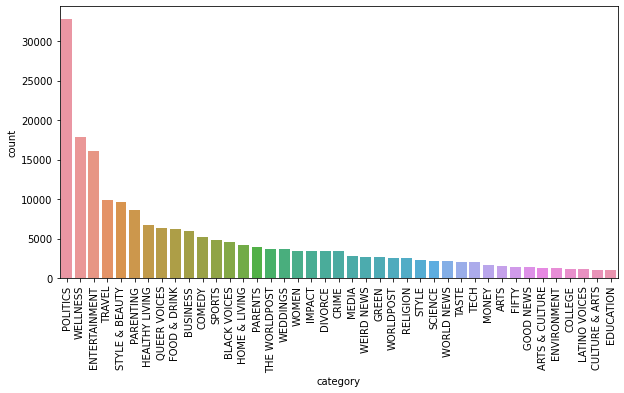

In [7]:
plt.figure(figsize = (10,5))
plt.xticks(rotation=90)
sns.countplot(new_data.category, order=new_data.category.value_counts().index)



---

---
# Data Cleaning

--- 
---




In [8]:
new_data.category = new_data.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
new_data.category = new_data.category.map(lambda x: "EDUCATION" if x == "COLLEGE" else x)
new_data.category = new_data.category.map(lambda x: "ARTS & CULTURE" if x == "ARTS" else x)
new_data.category = new_data.category.map(lambda x: "FOOD & DRINK" if x == "TASTE" else x)
new_data.category = new_data.category.map(lambda x: "PARENTING" if x == "PARENTS" else x)
new_data.category = new_data.category.map(lambda x: "STYLE & BEAUTY" if x == "STYLE" else x)
new_data.category = new_data.category.map(lambda x: "WORLDPOST" if x == "WORLD NEWS" else x)

In [9]:
print(new_data.category.nunique())
print(new_data.category.value_counts())

34
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
PARENTING         12632
STYLE & BEAUTY    11903
TRAVEL             9887
WORLDPOST          8420
FOOD & DRINK       8322
HEALTHY LIVING     6694
QUEER VOICES       6314
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
ARTS & CULTURE     2848
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
SCIENCE            2178
EDUCATION          2148
TECH               2082
MONEY              1707
FIFTY              1401
GOOD NEWS          1398
ENVIRONMENT        1323
LATINO VOICES      1129
CULTURE & ARTS     1030
Name: category, dtype: int64


## Handling Null Values

In [10]:
for i in new_data.columns:
  print(i)
  print(len(new_data[new_data[i] == ""]))
  print("--------------------")

category
0
--------------------
headline
6
--------------------
authors
36620
--------------------
short_description
19712
--------------------


In [11]:
new_data[new_data['headline'] == ""]

,category,headline,authors,short_description
82270,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",
86893,RELIGION,,"Matthew Fox, ContributorRadical theologian Mat...",Let everyone not wrapped in tired and disprove...
95001,WORLDPOST,,"Natasha Srdoc, ContributorAuthor, Economist, C...",
100426,BUSINESS,,"Gary Snyder, ContributorWriter and Media Strat...",
101479,MEDIA,,"Gary Snyder, ContributorWriter and Media Strat...",
113471,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",


In [12]:
new_data = new_data[new_data['headline'] != ""]

In [13]:
new_data = new_data[new_data['short_description'] != ""]

In [14]:
names = []
for i in new_data.authors:
  j = i.split()
  if len(j) >2:
    names.append(i)


In [15]:
new_data['authors'].replace("","Unknown",inplace = True)

In [16]:
authors = new_data.authors.str.split(",", n = 1,expand = True)

In [17]:
authors.isnull().sum()

0         0
1    103917
dtype: int64

In [18]:
len(authors[authors[0] == ""])

0

In [19]:
names[11]

'Jesselyn Cook and Nick Robins-Early'

In [20]:
new_data['authors_name'] = authors[0]
new_data['authors_description'] = authors[1]

In [21]:
new_data[new_data['authors_name'] == 'Unknown'][['category']].value_counts()

category      
WELLNESS          4998
POLITICS          2665
STYLE & BEAUTY    2558
PARENTING         2333
WEDDINGS          1948
FOOD & DRINK      1853
WORLDPOST         1817
DIVORCE           1731
TRAVEL            1397
ENTERTAINMENT     1278
QUEER VOICES       901
BLACK VOICES       862
HOME & LIVING      794
SPORTS             776
BUSINESS           757
CRIME              715
COMEDY             708
ENVIRONMENT        651
TECH               422
SCIENCE            371
CULTURE & ARTS     368
GREEN              364
WEIRD NEWS         319
MEDIA              299
WOMEN              262
MONEY              214
HEALTHY LIVING     193
LATINO VOICES      144
IMPACT             141
GOOD NEWS          122
RELIGION            96
EDUCATION           68
ARTS & CULTURE      32
dtype: int64

In [22]:
new_data.head()

,category,headline,authors,short_description,authors_name,authors_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,Melissa Jeltsen,None
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,Andy McDonald,None
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...,Ron Dicker,None
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...,Ron Dicker,None
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ...",Ron Dicker,None


In [23]:
print(f"There are {new_data.authors.nunique()} authors in our data")

There are 27136 authors in our data


In [24]:
df = new_data[['headline','short_description','category']]

In [25]:
df.reset_index(drop=True)
df.head()

,headline,short_description,category
0,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",ENTERTAINMENT


---
---
# Feature Engineering

---
---

In [26]:
df['total'] =df['headline'] + " " + df['short_description']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df.head(2)

,headline,short_description,category,total
0,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...


---
---
# Data preprocessing

---
---

In [56]:
df_cleaned = df[['total','category']]

In [39]:
stop_words = stopwords.words('english')

In [57]:
def expand_contractions(text):
  sent = ""
  for word in text.split():
    sent = sent + " " + contractions.fix(word)
  return sent.lower()

expand_contractions(df_cleaned.total[20])

" weird father's day gifts your dad does not know he wants (but he does) why buy a boring tie when you can give him testicle plush toys?"

In [58]:
def spell_check(text):
  spell = Speller()
  sent = " "
  spells = [spell(w) for w in (nltk.word_tokenize(text))]  
  return sent.join(spells)

spell_check(expand_contractions(df_cleaned.total[20]))

"weird father 's day gifts your dad does not know he wants ( but he does ) why buy a boring tie when you can give him textile plush toys ?"

In [60]:
def text_preprocess(data,x):
  lemmatizer = WordNetLemmatizer()
  for i,row in data.iterrows():
      filter_Sentence = ''

      sentence = row[x]
      sentence = expand_contractions(sentence)
      #sentence = spell_check(sentence)
      sentence = re.sub(r'[^\w\s]',' ',sentence)
      sentence = re.sub(r"\s+"," ", sentence, flags = re.I)#removing extra space
      sentence = re.sub(r"\d", " ", sentence)#removing digits
      sentence = re.sub(r"\s+[a-zA-Z]\s+", " ", sentence)#removing single characters
      sentence = re.sub(r"[,@\'?\.$%_]", "", sentence, flags=re.I)#removing multiple characters

      words = nltk.word_tokenize(sentence)

      #words = [w for w in words if not w in stop_words]

      for word in words:
          #filter_Sentence = filter_Sentence + ' ' + str(word)
          filter_Sentence = filter_Sentence + ' ' + str(lemmatizer.lemmatize(word))

      data.loc[i,x] = sentence
  return data

In [62]:
text_preprocess(df_cleaned,'total').head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,total,category
0,there were mass shootings in texas last week ...,CRIME
1,will smith joins diplo and nicky jam for the ...,ENTERTAINMENT
2,hugh grant marries for the first time at age ...,ENTERTAINMENT
3,jim carrey blasts castrato adam schiff and de...,ENTERTAINMENT
4,julianna margulies uses donald trump poop bag...,ENTERTAINMENT


In [63]:
df_cleaned.to_csv('clean.csv', index = False)

## Using TF-IDF

In [ ]:
#from google.colab import files
#files.upload()

In [66]:
df_cleaned = pd.read_csv("/content/clean.csv")
df_cleaned.head()

,total,category
0,there were mass shootings in texas last week ...,CRIME
1,will smith joins diplo and nicky jam for the ...,ENTERTAINMENT
2,hugh grant marries for the first time at age ...,ENTERTAINMENT
3,jim carrey blasts castrato adam schiff and de...,ENTERTAINMENT
4,julianna margulies uses donald trump poop bag...,ENTERTAINMENT


In [67]:
#df_cleaned.drop('Unnamed: 0', axis = 1, inplace = True)
df_cleaned.dropna(inplace=True)

In [68]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_cleaned['total'])

In [69]:
#X = vectorizer.fit_transform(df_cleaned['total'])
X.shape

(181140, 83559)

In [71]:
pickle.dump(tfidf, open("tfidf.pkl","wb"))

In [73]:
y = df_cleaned['category']

In [75]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)



---

---


# Model Building




---


---




## Using Logistic Regression

In [76]:
Lg = LogisticRegression(max_iter = 1000).fit(x_train,y_train)

In [77]:
pred = Lg.predict(x_test)
print(accuracy_score(y_test,pred))
print(matthews_corrcoef(y_test, pred))

0.6535552611239925
0.6266299638415338


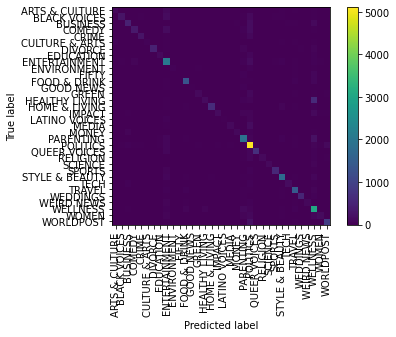

In [78]:
plot_confusion_matrix(Lg, x_test, y_test,xticks_rotation='vertical',include_values=False)

In [79]:
pickle.dump(Lg,open("LogisticRegression_model.pkl","wb"))

In [ ]:
#from google.colab import files
#files.download("/content/LogisticRegression_model.pkl")

## Using MultinomialNB

In [80]:
nb = MultinomialNB().fit(x_train,y_train)

In [81]:
pred = nb.predict(x_test)
print(accuracy_score(y_test,pred))
print(matthews_corrcoef(y_test, pred))

0.4408468587832616
0.3974195976432485


In [82]:
pickle.dump(nb,open("MultinomialNB_model.pkl","wb"))

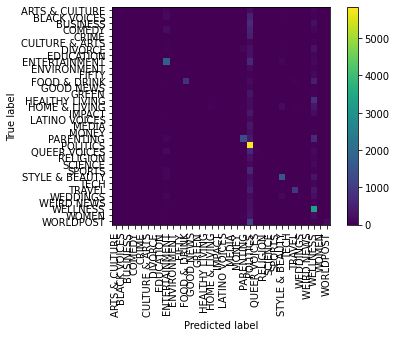

In [83]:
plot_confusion_matrix(nb, x_test, y_test,xticks_rotation='vertical',include_values=False)

# Using SVM

In [ ]:
sm = SVC(kernel='rbf').fit(x_train,y_train)

In [ ]:
pred = sm.predict(x_test)
print(accuracy_score(y_test,pred))
print(matthews_corrcoef(y_test, pred))

In [ ]:
plot_confusion_matrix(sm, x_test, y_test,xticks_rotation='vertical',include_values=False)

#Using Zeugma

In [ ]:
glove = EmbeddingTransformer('glove')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df_cleaned['short_description'], df_cleaned['category'], test_size = 0.3)

In [ ]:
x_train.shape

(126798,)

In [ ]:
X_train = glove.transform(x_train)
X_train.shape

(126798, 25)

In [ ]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X_test = glove.transform(x_test)

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred

array(['POLITICS', 'POLITICS', 'ENTERTAINMENT', ..., 'POLITICS',
       'WELLNESS', 'POLITICS'], dtype=object)

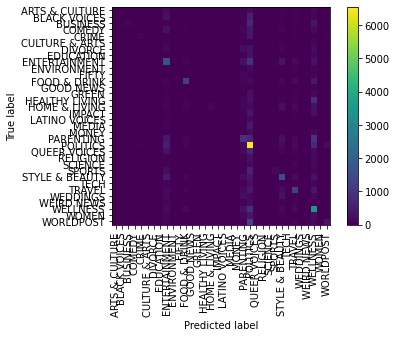

In [ ]:
plot_confusion_matrix(model, X_test, y_test,xticks_rotation='vertical',include_values=False)

In [ ]:
accuracy_score(y_test, pred)

0.3220345221007692